In [7]:
import pandas as pd
import numpy as np
from nltk import sent_tokenize,word_tokenize
from textblob import TextBlob
from nltk import FreqDist
import itertools
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Loads pickled data:

In [8]:
df_first_clean = pd.read_pickle('pickled_data/data_first_clean.pkl')
df_second_clean = pd.read_pickle('pickled_data/data_second_clean.pkl')

## Sentiment analysis 

In [9]:
#Sentiment analysis on Polarity and Subjectivity for all speeches using TextBlob:
def sentiment(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None
    
df_first_clean['Polarity'] = df_first_clean['first_clean'].apply(sentiment).apply(lambda x: x[0])
df_first_clean['Subjectivity'] = df_first_clean['first_clean'].apply(sentiment).apply(lambda x: x[1])

df_first_clean.to_pickle('pickled_data/data_first_clean_sentiment.pkl')

df_first_clean

,year,President,Party,speech,first_clean,first_clean_tokenized,Polarity,Subjectivity
0,1900,William McKinley,Republican,To the Senate and House of Representatives: \n...,to the senate and house of representatives: at...,"[senate, house, representatives, outgoing, old...",0.115256,0.404176
1,1901,Theodore Roosevelt,Republican,To the Senate and House of Representatives: \n...,to the senate and house of representatives: th...,"[senate, house, representatives, congress, ass...",0.139217,0.471688
2,1902,Theodore Roosevelt,Republican,To the Senate and House of Representatives: \n...,to the senate and house of representatives: we...,"[senate, house, representatives, still, contin...",0.120273,0.497860
3,1903,Theodore Roosevelt,Republican,To the Senate and House of Representatives: \n...,to the senate and house of representatives: th...,"[senate, house, representatives, country, cong...",0.119628,0.456306
4,1904,Theodore Roosevelt,Republican,To the Senate and House of Representatives: \n...,to the senate and house of representatives: th...,"[senate, house, representatives, nation, conti...",0.137607,0.500679
...,...,...,...,...,...,...,...,...
116,2017,Donald Trump,Republican,"Mr. Speaker, Mr. Vice President, Members of Co...","mr. speaker, mr. vice president, members of co...","[mr, speaker, mr, vice, president, members, co...",0.146113,0.450257
117,2018,Donald Trump,Republican,"Mr. Speaker, Mr. Vice President, Members of Co...","mr. speaker, mr. vice president, members of co...","[mr, speaker, mr, vice, president, members, co...",0.113485,0.485158
118,2019,Donald Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...","madam speaker, mr. vice president, members of ...","[madam, speaker, mr, vice, president, members,...",0.114962,0.449762
119,2020,Donald Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...","madam speaker, mr. vice president, members of ...","[madam, speaker, mr, vice, president, members,...",0.137910,0.452048


### Sentiment analysis based on economic growth


In [10]:
#Selection of years of economic crisis or growth:
list_economic_crisis = [1930, 1931, 1932, 1986, 1987, 1988, 2008, 2009, 2010]
list_economic_growth = [1926, 1927, 1928, 1992, 1993, 1994, 2005, 2006, 2007]

#### Main method for the analysis

In [11]:
def method_financial_sentiment(speech):
    #We remove '\n':
    speech = speech.replace('\n', '')
    
    #We split the speech into sentences to optimize for nltk.sentiment:
    list_sentences = speech.split(sep='. ')
    
    #Add all the polarity scores of the sentences to a list:
    scores = []
    
    for sentence in list_sentences:
        sentimentIntensityAnalyzer = SentimentIntensityAnalyzer()
        scores.append(sentimentIntensityAnalyzer.polarity_scores(sentence))
    
    #Sums and finds average polarity for each speech:
    list_all_posistive = []
    list_all_neutral = []
    list_all_negative = []
    list_all_compound = []
    
    for score in scores:
        for key, value in score.items():
            if key == 'pos':
                list_all_posistive.append(value)
            if key == 'neu':
                list_all_neutral.append(value)
            if key == 'neg':
                list_all_negative.append(value)
            if key == 'compound':
                list_all_compound.append(value)
                
    avg_posistive = round(sum(list_all_posistive) / len(list_all_posistive), 4)
    avg_neutral = round(sum(list_all_neutral) / len(list_all_neutral), 4)
    avg_negative = round(sum(list_all_negative) / len(list_all_negative), 4)
    avg_compound = round(sum(list_all_compound) / len(list_all_compound), 4)
     
    #Result is a dictionary of the same format as from the original 'SentimentIntensityAnalyzer..polarity_scores()' method:
    result = {'neg': avg_negative, 'neu': avg_neutral, 'pos': avg_posistive, 'compound': avg_compound}
    
    #Return result
    return result

#### Test of the method

In [12]:
#Simple sentences:
positive_sentence_1 = 'I love CPHBusiness and I think it is the best school'
negative_sentence_1 = 'I hate CPHBusienss and I think it is the worst school'


print('SIMPLE:')
print('Positive:')
print(method_financial_sentiment(positive_sentence_1))
print('Negative:')
print(method_financial_sentiment(negative_sentence_1))


#Complex sentences (from 2002 speech):
positive_sentence_2 = 'America and Afghanistan are now allies against terror. We will be partners in rebuilding that country. And this evening we welcome the distinguished interim leader of a liberated Afghanistan: Chairman Hamid Karzai. The last time we met in this chamber, the mothers and daughters of Afghanistan were captives in their own homes, forbidden from working or going to school. Today women are free, and are part of Afghanistans new government. And we welcome the new Minister of Womens Affairs, Doctor Sima Samar.'
negative_sentence_2 = 'What we have found in Afghanistan confirms that, far from ending there, our war against terror is only beginning. Most of the 19 men who hijacked planes on September the 11th were trained in Afghanistans camps, and so were tens of thousands of others.  Thousands of dangerous killers, schooled in the methods of murder, often supported by outlaw regimes, are now spread throughout the world like ticking time bombs, set to go off without warning. '

print('\nCOMPLEX:')
print('(Slightly) Positive:')
print(method_financial_sentiment(positive_sentence_2))
print('Negative:')
print(method_financial_sentiment(negative_sentence_2))


#Before and after 9/11:
speech_2001 = df_second_clean['speech'][100]
speech_2002 = df_second_clean['speech'][101]

print('\nBEFORE AND AFTER 9/11:')
print('Before (2001):')
print(method_financial_sentiment(speech_2001))
print('After (2002):')
print(method_financial_sentiment(speech_2002))


SIMPLE:
Positive:
{'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.8555}
Negative:
{'neg': 0.527, 'neu': 0.473, 'pos': 0.0, 'compound': -0.8316}

COMPLEX:
(Slightly) Positive:
{'neg': 0.0707, 'neu': 0.823, 'pos': 0.1063, 'compound': 0.08}
Negative:
{'neg': 0.1437, 'neu': 0.5673, 'pos': 0.039, 'compound': -0.4032}

BEFORE AND AFTER 9/11:
Before (2001):
{'neg': 0.0508, 'neu': 0.7787, 'pos': 0.1705, 'compound': 0.2977}
After (2002):
{'neg': 0.1309, 'neu': 0.6953, 'pos': 0.1738, 'compound': 0.0734}


#### Sentiment analysis using the main method

In [13]:
# Initializes dataframe and removes unused column (if exists):
df_economic_sentiment = df_second_clean.copy()
if 'second_clean_lemmatized' in df_economic_sentiment.columns:
    del df_economic_sentiment['second_clean_lemmatized']
    
# Uses lists created above to select years of crisis and growth:
df_crisis = df_economic_sentiment.loc[df_economic_sentiment['year'].isin(list_economic_crisis), ['speech']]
df_growth = df_economic_sentiment.loc[df_economic_sentiment['year'].isin(list_economic_growth), ['speech']]

##### Result A: We get one combined result for crisis and growth periods 

In [14]:
# Combines all speeches from the selected years of crisis and growth:
crisis_speeches = ''.join(df_crisis.speech)
growth_speeches = ''.join(df_growth.speech)

# Uses main method to perform sentiment analysis:
dict_crisis_result = method_financial_sentiment(crisis_speeches)
dict_growth_result = method_financial_sentiment(growth_speeches)

# Print result (plot doesn't make sense here):
print('CRISIS YEARS:')
print(dict_crisis_result)
print('\nGROWTH YEARS:')
print(dict_growth_result)

CRISIS YEARS:
{'neg': 0.0716, 'neu': 0.7992, 'pos': 0.1292, 'compound': 0.1554}

GROWTH YEARS:
{'neg': 0.0648, 'neu': 0.8012, 'pos': 0.134, 'compound': 0.1784}


##### Result B: Results for each speech is added to DataFrame (for potential further analysis)

In [15]:
# Adds result to main DataFrame:
df_economic_sentiment['sentiment_crisis'] = df_crisis.speech.apply(method_financial_sentiment)
df_economic_sentiment['sentiment_growth'] = df_growth.speech.apply(method_financial_sentiment)

# Removes 'speech' column (if exists):
if 'speech' in df_economic_sentiment.columns:
    del df_economic_sentiment['speech']

# Removes all years from DataFrame that is not part of the analysis:
df_economic_sentiment = df_economic_sentiment.dropna(subset=['sentiment_crisis', 'sentiment_growth'], thresh=1)

#Print result:
df_economic_sentiment

,year,President,Party,sentiment_crisis,sentiment_growth
26,1926,Calvin Coolidge,Republican,NaN,"{'neg': 0.0566, 'neu': 0.8211, 'pos': 0.1223, ..."
27,1927,Calvin Coolidge,Republican,NaN,"{'neg': 0.0518, 'neu': 0.8241, 'pos': 0.1241, ..."
28,1928,Calvin Coolidge,Republican,NaN,"{'neg': 0.041, 'neu': 0.841, 'pos': 0.1179, 'c..."
30,1930,Herbert Hoover,Republican,"{'neg': 0.0592, 'neu': 0.8518, 'pos': 0.089, '...",NaN
31,1931,Herbert Hoover,Republican,"{'neg': 0.0618, 'neu': 0.8198, 'pos': 0.1184, ...",NaN
32,1932,Herbert Hoover,Republican,"{'neg': 0.0761, 'neu': 0.8096, 'pos': 0.1143, ...",NaN
85,1986,Ronald Reagan,Republican,"{'neg': 0.0804, 'neu': 0.7426, 'pos': 0.177, '...",NaN
86,1987,Ronald Reagan,Republican,"{'neg': 0.0577, 'neu': 0.8056, 'pos': 0.1368, ...",NaN
87,1988,Ronald Reagan,Republican,"{'neg': 0.0569, 'neu': 0.796, 'pos': 0.147, 'c...",NaN
91,1992,George Bush,Republican,NaN,"{'neg': 0.0636, 'neu': 0.8088, 'pos': 0.1245, ..."


## Text complexity (LIX)


#### Definition of LIX

<b>Calculation:</b>

<img src="./images/lix.png" align=left>

<br><br>

<p>where</p>

<ul>
<li>A is the number of words,</li>
<li>B is the number of periods (defined by period or colon), and</li>
<li>C is the number of long words (more than 6 letters).</li>
</ul>
<p><i>Source: Wikipedia</i><p>
<br>

<b>Scores:</b>
<ul>
    <li>Greater than 54: Very difficult</li>
    <li>Between 45-54 Difficult</li>
    <li>Between 35-44 Medium</li>
    <li>Between 25-34 Easy</li>
    <li>Less than 25: Very easy</li>
</ul>


#### LIX analysis

In [16]:
# Copy main dataframe (first clean - we don't want lemmatization here!):
df_lix = df_first_clean.copy()
df_lix = df_lix.drop(columns = ['speech', 'first_clean_tokenized'])


# WORD COUNT:
# Method to calculate total words in each speach:
def word_count(speech):
    return sum(1 for word in speech.split(' '))

# Get total words in each speech and add result to DataFrame:
df_lix['word_count'] = df_lix.first_clean.apply(word_count)


# COUNT OF PERIODS:
# Method to calculate total number of periods (period or colon) in each speach:
def period_count(speech):
    result = speech.count('.') + speech.count(':')
    return result

# Get total number of periods in each speech and add result to DataFrame:
df_lix['period_count'] = df_lix.first_clean.apply(period_count)


# COUNT OF LONG WORDS:
# Method to long words (< 6 characters) in each speach:
def long_word_count(speech):
    count = 0
    for word in speech.split(' '):
        if len(word) > 6:
            count += 1
    return count

# Get total number of long words in each speech and add result to DataFrame:
df_lix['long_words_count'] = df_lix.first_clean.apply(long_word_count)


# CALCULATE LIX:
# Calculates LIX for each speech and adds result to DataFrame:
df_lix['lix'] = (df_lix.word_count/df_lix.period_count) + ((df_lix.long_words_count*100) / df_lix.word_count)

#### Present results from LIX analysis:

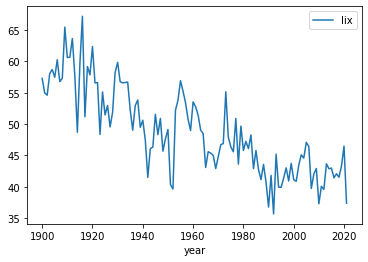

In [17]:
# Development in LIX over the years for all speeches:
df_lix.plot(x = 'year', y = 'lix')

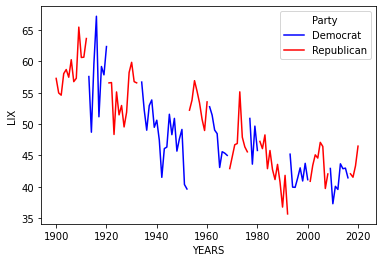

In [18]:
# Development in LIX showing difference between Democrats and Republicans:
df_lix_party = df_lix.copy()

df_lix_party = df_lix.pivot(index='year', columns='Party', values='lix')
df_lix_party.plot(color=['blue', 'red'])

plt.ylabel('LIX')
plt.xlabel('YEARS')
plt.show()

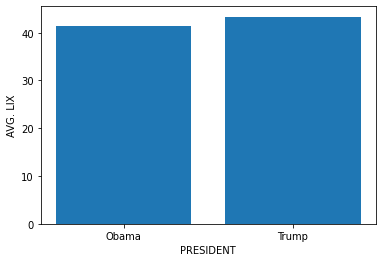

In [19]:
# Comparison of between speeches performed by Obama and Trump:
mask_obama = (df_lix['President'] == 'Barack Obama')
mask_trump = (df_lix['President'] == 'Donald Trump')

avg_lix_obama = df_lix[mask_obama]['lix'].mean()
avg_lix_trump = df_lix[mask_trump]['lix'].mean()

x = ["Obama", "Trump"]
y = [avg_lix_obama, avg_lix_trump]


plt.bar(x,y)
plt.ylabel('AVG. LIX')
plt.xlabel('PRESIDENT')
plt.show()



## Word frequency 

### Before lemmatization

In [20]:
#Masks to filter on democrats and republicans
mask_democrats = (df_first_clean['Party'] == 'Democrat')
mask_republicans = (df_first_clean['Party'] == 'Republican')

#DEMOCRATS:
#Filter dataframe on democrats:
df_first_clean_democrats = df_first_clean[mask_democrats]
#Takes 'first_clean_tokenized' column and converts to list:
tokenized_speeches_democrats = df_first_clean_democrats['first_clean_tokenized'].tolist()
#Combines list of lists into one list:
tokenized_speeches_democrats = list(itertools.chain.from_iterable(tokenized_speeches_democrats))

#Republicans:
#Filter dataframe on republicans:
df_first_clean_republicans = df_first_clean[mask_republicans]
#Takes 'first_clean_tokenized' column and converts to list:
tokenized_speeches_republicans = df_first_clean_republicans['first_clean_tokenized'].tolist()
#Combines list of lists into one list:
tokenized_speeches_republicans = list(itertools.chain.from_iterable(tokenized_speeches_republicans))

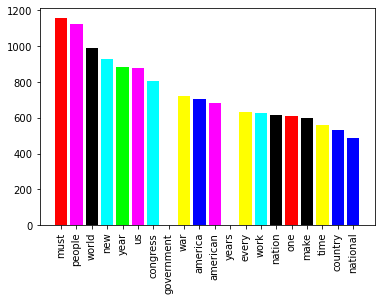

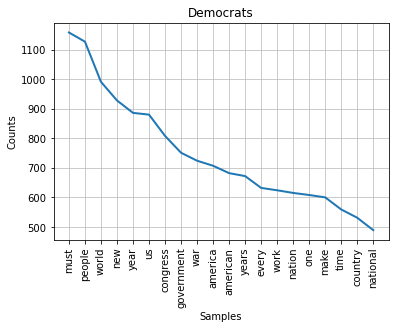

[('must', 1158),
 ('people', 1127),
 ('world', 991),
 ('new', 928),
 ('year', 886),
 ('us', 880),
 ('congress', 808),
 ('government', 751),
 ('war', 724),
 ('america', 707),
 ('american', 682),
 ('years', 672),
 ('every', 632),
 ('work', 624),
 ('nation', 615),
 ('one', 608),
 ('make', 600),
 ('time', 559),
 ('country', 531),
 ('national', 489)]

In [21]:
#Checks word freq in all democrat speeches:
freqDist_democrats = FreqDist(tokenized_speeches_democrats)

dem_to_dict = dict(freqDist_democrats.most_common(20))

l = []

for i in range(0, len(dem_to_dict)+1):
    l.append(tuple(np.random.choice(range(0, 2), size=3)))
    
plt.bar(*zip(*dem_to_dict.items()), color=l)
plt.xticks(rotation=90)

plt.show()

freqDist_democrats.plot(20, title='Democrats')
freqDist_democrats.most_common(20)

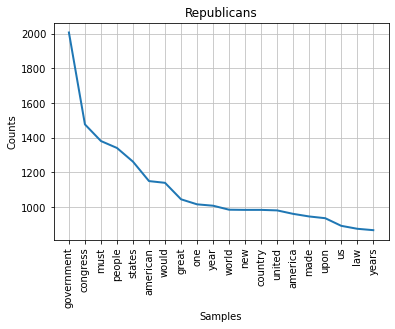

[('government', 2007),
 ('congress', 1477),
 ('must', 1381),
 ('people', 1341),
 ('states', 1262),
 ('american', 1150),
 ('would', 1140),
 ('great', 1045),
 ('one', 1016),
 ('year', 1008),
 ('world', 985),
 ('new', 984),
 ('country', 984),
 ('united', 981),
 ('america', 961),
 ('made', 946),
 ('upon', 936),
 ('us', 892),
 ('law', 875),
 ('years', 867)]

In [22]:
#Checks word freq in all republican speeches:
freqDist_republicans = FreqDist(tokenized_speeches_republicans)

freqDist_republicans.plot(20, title='Republicans')
freqDist_republicans.most_common(20)

### After lemmatization

In [23]:
#Masks to filter on democrats and republicans
mask_democrats = (df_second_clean['Party'] == 'Democrat')
mask_republicans = (df_second_clean['Party'] == 'Republican')

#DEMOCRATS:
#Filter dataframe on democrats:
df_second_clean_democrats = df_second_clean[mask_democrats]
#Takes 'second_clean_lemmatized' column and converts to list:
lemmatized_speeches_democrats = df_second_clean_democrats['second_clean_lemmatized'].tolist()
#Combines list of lists into one list:
lemmatized_speeches_democrats = list(itertools.chain.from_iterable(lemmatized_speeches_democrats))

#Republicans:
#Filter dataframe on republicans:
df_second_clean_republicans = df_second_clean[mask_republicans]
#Takes 'second_clean_lemmatized' column and converts to list:
lemmatized_speeches_republicans = df_second_clean_republicans['second_clean_lemmatized'].tolist()
#Combines list of lists into one list:
lemmatized_speeches_republicans = list(itertools.chain.from_iterable(lemmatized_speeches_republicans))

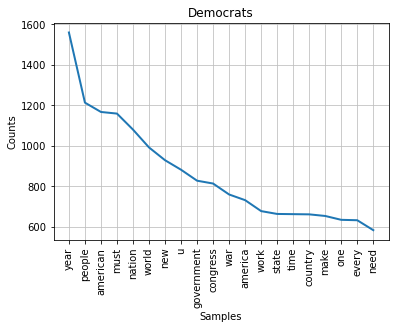

[('year', 1558),
 ('people', 1212),
 ('american', 1166),
 ('must', 1158),
 ('nation', 1079),
 ('world', 991),
 ('new', 928),
 ('u', 881),
 ('government', 827),
 ('congress', 813),
 ('war', 759),
 ('america', 731),
 ('work', 677),
 ('state', 663),
 ('time', 662),
 ('country', 661),
 ('make', 653),
 ('one', 634),
 ('every', 632),
 ('need', 583)]

In [24]:
#Checks word freq in all democrat speeches:
freqDist_democrats = FreqDist(lemmatized_speeches_democrats)

freqDist_democrats.plot(20, title='Democrats')
freqDist_democrats.most_common(20)

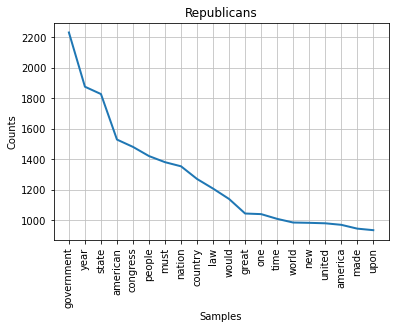

[('government', 2230),
 ('year', 1875),
 ('state', 1827),
 ('american', 1529),
 ('congress', 1481),
 ('people', 1421),
 ('must', 1381),
 ('nation', 1354),
 ('country', 1271),
 ('law', 1208),
 ('would', 1140),
 ('great', 1045),
 ('one', 1041),
 ('time', 1010),
 ('world', 986),
 ('new', 984),
 ('united', 981),
 ('america', 971),
 ('made', 946),
 ('upon', 936)]

In [25]:
#Checks word freq in all republican speeches:
freqDist_republicans = FreqDist(lemmatized_speeches_republicans)

freqDist_republicans.plot(20, title='Republicans')
freqDist_republicans.most_common(20)